# Classificador de Músicas para o Spotify
---

Os serviços de **streaming** já fazem há alguns anos, parte da vida das pessoas por sua **facilidade** e **acessibilidade**.

Dentre os vários motivos para isso estão a sua acessibilidade e facilidade de utilização para o usuário e recorrência na receita dos detentores da tecnologia, uma vez que mensalmente as pessoas pagam para utilizar.


Mas, você sabe o que é streaming?


São serviços que permitem que algum **conteúdo seja transmitido via internet** sem necessidade de baixar, visualizar conteúdo de propaganda ou até mesmo perder tempo procurando e também correr risco de contaminar o smartphone ou computador com virus.

**Exemplos** de serviços de streaming são a **Netflix** em filmes e **Spotify** em música. Você provavelmente conhece ambas.

![spotify](https://image.freepik.com/fotos-gratis/jovem-casal-ouvindo-musica-com-app-spotify_23-2147987797.jpg)

## Sobre o projeto

O objetivo aqui é utilizar **dados disbonibilizados pela própria Spotify** para criar um **classificador** que tem por objetivo **identificar possíves músicas que um usuário possa gostar**.


As informações originais sobre as **features** estão [aqui](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

## Checklist

1. Definição do Problema
2. Análise exploratória de dados
3. Pré-processamento
4. Pipeline e Machine Learning
5. Tuning do modelo

# 1. Definição do Problema

Não apenas em serviços de streaming, mas em qualquer empresa que oferece algum tipo de serviço ou produto busca ser mais acertivo em suas indicações ao usuários, veja a Amazon, por exemplo, se você acaba de criar um conta nela, não há de antemão nada que te interesse, mas a partir do momento que você começa a comprar ou a salvar itens, ou colocar no carrinho, **indicações** começam a surgir.

Do mesmo modo faz a Netflix ou o Spotify, ao criar sua conta nesta não há nenhum tipo de indicação a não ser o que está em alta. Mas, não necessariamente você gosta do que todos gostam, não é mesmo?! Os **algoritmos não têm como adivinhar**, então **a partir do momento que você começa a ouvir músicas, outras são sugeridas a você**!

Algumas medidas são utilizadas para classificar isso, como por exemplo se a música permite dançar ou a duração da música etc. Na parte de análise exploratória será abordada cada feature.

**Importando bibliotecas necessárias**

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

**Lendo a base de dados**

In [2]:
dataset= pd.read_csv('/home/amador/dados/data.csv', sep=',')

**Visualizando primeiros dados**

In [3]:
dataset.head()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


# 2. Análise exploratória de dados

* **'id'**
    * O número de identificação da música
* **'acousticness'**
    * Indica se a música é ou não acústica, 0,0 para não acústica e 1,0 para o máximo de acusticidade.
* **'danceability'**
    * Descreve como uma faixa é adequada para dançar com base em uma combinação de elementos musicais, incluindo tempo, estabilidade de ritmo, força de batida e regularidade geral. Um valor de 0,0 é menos dançável e 1,0 é mais dançante.
* **'duration_ms'**
    * A duração da faixa de música em milissegundos
* **'energy'**
    * É uma medida de 0,0 (menos energética possivel) a 1,0 (mais energética possivel) que representa uma medida de intensidade e atividade da música. Normalmente, as faixas energéticas parecem rápidas, altas e barulhentas. Por exemplo, death metal tem alta energia, enquanto um prelúdio de Bach tem pontuação baixa na escala. As características perceptivas que contribuem para este atributo incluem faixa dinâmica, intensidade percebida, timbre, taxa de início e entropia geral.
* **'instrumentalness'**
     * Prediz se uma faixa não contém vocais. Os sons “Ooh” e “aah” são tratados como instrumentais neste contexto. Faixas de rap ou palavra falada são claramente “vocais”. Quanto mais próximo o valor da instrumentalidade estiver de 1,0, maior será a probabilidade de a faixa não conter conteúdo vocal. Valores acima de 0,5 destinam-se a representar faixas instrumentais, mas a confiança é maior à medida que o valor se aproxima de 1,0. 
* **'key'**
    * Basicamente o tom da música, onde: 
        * 0 = C
        * 1 = Db
        * 2 = D
        * 3 = Eb
        * 4 = E
        * 5 = F
        * 6 = Gb
        * 7 = G
        * 8 = Ab
        * 9 = A
        * 10 = Bb
        * 11 = B
* **'liveness'**
    * Detecta a presença de um público na gravação. Valores de vivacidade mais altos representam um aumento na probabilidade de a trilha ter sido executada ao vivo. Um valor acima de 0,8 fornece uma grande probabilidade de que a faixa esteja ao vivo. 
* **'loudness'**
    * O volume geral de uma faixa em decibéis (dB). Os valores de intensidade são calculados em toda a faixa e são úteis para comparar a intensidade relativa das faixas. Loudness é a qualidade de um som que é o principal correlato psicológico da força física (amplitude). Os valores típicos variam entre -60 e 0 db. 
* **'speechiness'**
    * Detecta a presença de palavras faladas em uma faixa. Quanto mais exclusivamente falada for a gravação (por exemplo, talk show, audiolivro, poesia), mais próximo de 1,0 será o valor do atributo. Valores acima de 0,66 descrevem faixas que provavelmente são compostas inteiramente de palavras faladas. Os valores entre 0,33 e 0,66 descrevem faixas que podem conter música e fala, em seções ou em camadas, incluindo casos como música rap. Valores abaixo de 0,33 provavelmente representam música e outras faixas não semelhantes à fala. 
* **'tempo'**
    * Não confunda! Nada tem a ver com o tempo da música, mas sim com as batidas por minuto (BPM). Na terminologia musical, o tempo é a velocidade ou ritmo de uma determinada peça e deriva diretamente da duração média da batida. 
* **'time_signature'**
    * Uma fórmula de compasso geral estimada em uma faixa. A assinatura de tempo (medidor) é uma convenção notacional para especificar quantas batidas existem em cada barra (ou medida). Normalmente é 4 por as músicas serem normalmente 4/4.
* **'valence'**
    * Uma medida de 0,0 a 1,0 que descreve a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórico), enquanto faixas com baixa valência soam mais negativas (por exemplo, triste, deprimido, zangado).
* **'target'**
    * Define se os usuários gostaram ou não da músicas:
        * 0 = Não gostaram
        * 1= Gostaram
* **'song_title'**
    * Nome da faixa.
* **'artist'**
    * O nome do artista ou banda.

**Q1. Há valores nulos em nossa base de dados?** 

Não!

In [4]:
dataset.isnull().sum()

id                  0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

**Q2. Há valores em nossa variável alvo além de 0 e 1?** 

Não Há!

Lembrando que os valores 0 são para músicas que os usuários não gostaram e os 1 para os que gostaram.

In [5]:
dataset.target.unique()

array([1, 0])

**Q3. Como é a distribuição estatística dos dados?**

In [6]:
dataset.describe()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


**À frente veremos alguns plots de dados**

Aqui há os estilos disponíveis na biblioteca **Matplotlib**.

In [7]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

**Os plots servirão para encontrarmos algum tipo de padrão entre os dados**

**Q4. Há alguma relação entre as variáveis `'acousticness'` e `'danceability'`?**

Aparentemente não.

<IPython.core.display.Javascript object>


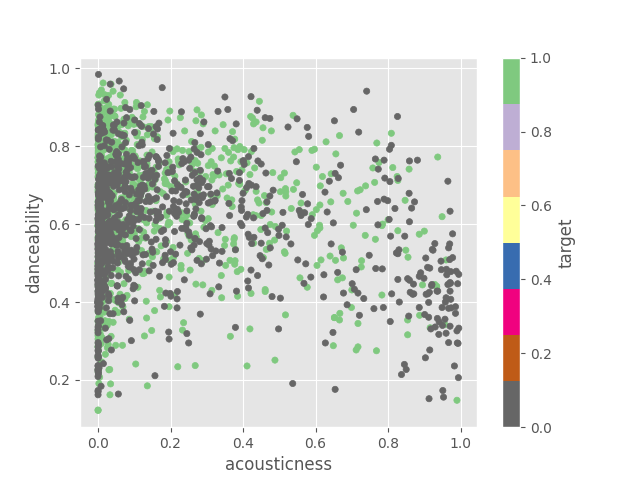

In [8]:
%matplotlib notebook
style.use("seaborn-colorblind")
dataset.plot(x='acousticness', y='danceability', c='target', kind='scatter', colormap='Accent_r');

**Q5. Há alguma relação entre as variáveis `'tempo'` e `'valence'`?**

Aparentemente não também.

<IPython.core.display.Javascript object>


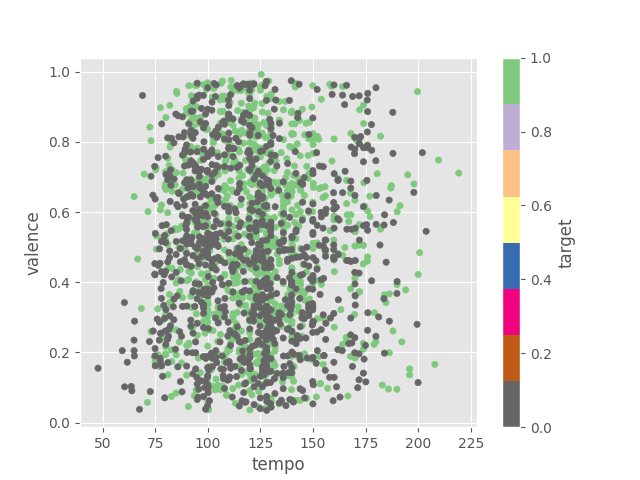

In [9]:
%matplotlib notebook
style.use("seaborn-colorblind")
dataset.plot(x='tempo', y='valence', c='target', kind='scatter' , colormap='Accent_r');

**Q6. Há alguma relação entre as variáveis `'tempo'` e `'speechiness'`?**

Aparentemente não mais uma vez.

<IPython.core.display.Javascript object>


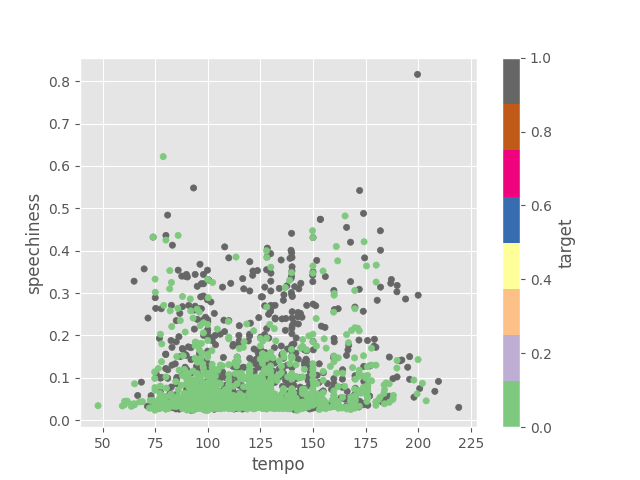

In [10]:
%matplotlib notebook
style.use("seaborn-colorblind")
dataset.plot(x='tempo', y='speechiness', c='target', kind='scatter' , colormap='Accent');

**Q7. Há alguma relação entre as variáveis `'danceability'` e `'energy'`?**

Mais uma vez, não.

<IPython.core.display.Javascript object>


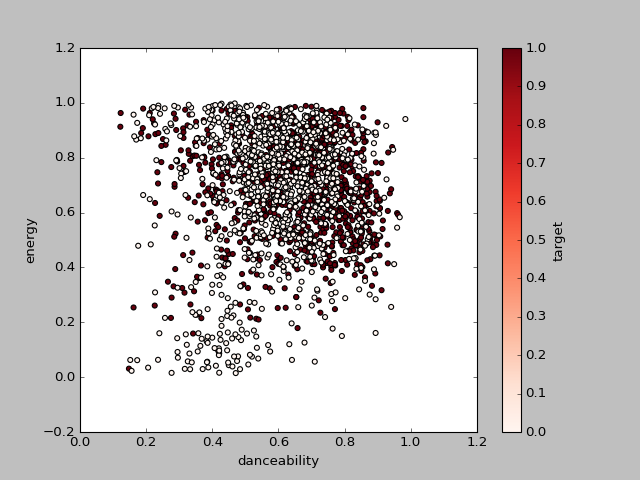

In [11]:
%matplotlib notebook
style.use('classic')
dataset.plot(x='danceability', y='energy', c='target', kind='scatter' , colormap='Reds');

**Teste!**

Não encontramos nenhuma correlação entre as features, contudo nosso teste não foi exaustivo e você pode testar as diversas combinações para encontrar alguma correlação que possa importar.

# 3. Pré-processamento

Aqui utilizaremos duas abordagens que você pode entender melhor [aqui](https://github.com/danielamador12/public-projects/blob/master/pr%C3%A1tica_pre-processamento_e_metricas.ipynb).

Utilizaremos o One Hot Encoder e Label Encoder e após isso, utilizaremos o Get Dummies.

**Dividindo os dados**

In [12]:
classes = dataset['target']
dataset.drop('target', axis=1, inplace=True) # dataset terá todos os dados, exceto o target(classes)

**Criando função pra remover coluna sempre que necessário**

In [13]:
def remove_features(lista_features):
    for i in lista_features:
        dataset.drop(i, axis=1, inplace=True)
    return 'OK'

**Removendo features não-representativas**

O id da música a faixa da música são valores únicos que não terão importância em nosso modelo.

In [14]:
remove_features(['id','song_title'])

'OK'

**Visualizando o novo dataset**

Já com as features removidas.

In [15]:
dataset.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.165,-8.795,1,0.4310,150.062,4.0,0.286,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.137,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.159,-7.148,1,0.2890,75.044,4.0,0.173,Future


**Vamos verificar algums informações das colunas**

Somente para ver se está tudo certo.

Aparentemente está.

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  artist            2017 non-null   object 
dtypes: float64(10), int64(3), object(1)
memory usage: 220.7+ KB


## Label Encoder

**Criando o objeto Label Encoder**

In [17]:
# importando a biblioteca
from sklearn.preprocessing import LabelEncoder
# instanciando o objeto
enc = LabelEncoder()
# inteiros recebe a coluna 'artist' transformada
inteiros = enc.fit_transform(dataset['artist'])
#tipo da coluna
type(dataset['artist']),type(inteiros)

(pandas.core.series.Series, numpy.ndarray)

**Visualizando valores únicos**

Da coluna *'artist'* já transformada.

Os arrays numpy não suportam o unique.

In [18]:
set(inteiros)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


**Criando uma nova coluna chamada 'artist_inteiros'**

Para atribuir posteriormente ao DataFrame.

In [19]:
dataset['artist_inteiros'] = inteiros

**Fazendo copia do dataset com a feature artist categórico**

Para pode utilizar novamente depois com seu formato original, ou seja, categórico.

In [20]:
dataset_com_artist=dataset.copy()

**Removendo 'artist'**

In [21]:
remove_features(['artist'])

'OK'

**Visualizando dataset ainda com 'artist'**

In [22]:
dataset_com_artist.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.165,-8.795,1,0.4310,150.062,4.0,0.286,Future,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.137,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.159,-7.148,1,0.2890,75.044,4.0,0.173,Future,449


**Visualizando dataset sem 'artist'**

In [23]:
dataset.head(3) # não tem mais a feature artist

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.165,-8.795,1,0.4310,150.062,4.0,0.286,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.137,-10.401,1,0.0794,160.083,4.0,0.588,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.159,-7.148,1,0.2890,75.044,4.0,0.173,449


## One Hot Encoding

In [24]:
# importando o pacote OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# instanciando um objeto do tipo OnehotEncoder
ohe = OneHotEncoder()

**A função .values pega todos os valores como array**

In [25]:
dataset.values

array([[1.02000e-02, 8.33000e-01, 2.04600e+05, ..., 4.00000e+00,
        2.86000e-01, 4.49000e+02],
       [1.99000e-01, 7.43000e-01, 3.26933e+05, ..., 4.00000e+00,
        5.88000e-01, 2.22000e+02],
       [3.44000e-02, 8.38000e-01, 1.85707e+05, ..., 4.00000e+00,
        1.73000e-01, 4.49000e+02],
       ...,
       [8.57000e-03, 6.37000e-01, 2.07200e+05, ..., 4.00000e+00,
        4.70000e-01, 9.47000e+02],
       [1.64000e-03, 5.57000e-01, 1.85600e+05, ..., 4.00000e+00,
        6.23000e-01, 1.24200e+03],
       [2.81000e-03, 4.46000e-01, 2.04520e+05, ..., 4.00000e+00,
        4.02000e-01, 1.32000e+02]])

**Transformando em array numpy o dataset**

Se você viu o [notebook](https://github.com/danielamador12/public-projects/blob/master/pr%C3%A1tica_pre-processamento_e_metricas.ipynb) viu que o One Hot Encoder requer um pouco mais de trabalho

In [26]:
dataset_array = dataset.values
dataset_array.shape

(2017, 14)

**Pegando o numero de linhas e salvando em uma variável**

In [27]:
num_rows = dataset_array.shape[0] # shape[0] significa pegar o shape (ou tamanho) de linhas
num_rows

2017

**Visualizando coluna de inteiros**

Que é nossa coluna com os artistas já codificados com o *Label Encoder*.

A coluna que se quer é a 14º. O 13 é porque vai de 0 a 13.

In [28]:
dataset_array[:][:,13]

array([ 449.,  222.,  449., ...,  947., 1242.,  132.])

**Transformando a matriz em uma dimensão**

len(inteiros) é para pegar o tamanho de linhas baseado no inteiros (2017).

1 é o numero de dimensões.

In [29]:
inteiros = inteiros.reshape(len(inteiros),1)
type(inteiros),inteiros.shape

(numpy.ndarray, (2017, 1))

**Criando as novas features a partir da matriz de presença**

In [30]:
# criando as novas features 
novas_features = ohe.fit_transform(inteiros)
# imprimindo as novas features
novas_features
# são 1343 colunas presentes em 2017 linhas

<2017x1343 sparse matrix of type '<class 'numpy.float64'>'
	with 2017 stored elements in Compressed Sparse Row format>

**Vamos visualizar o tipo das colunas**

Veja que agora é uma *matriz esparsa*.

In [31]:
type(novas_features)

scipy.sparse.csr.csr_matrix

**Concatenando e visualizandos as features**

In [32]:
# Concatenando as novas features ao array em formato array
dataset_array = np.concatenate([dataset_array, novas_features.toarray()], axis=1)
# Visualizando a quantidade de linhas e colunas da base
dataset_array.shape

(2017, 1357)

**Transformando em DataFrame e visualizando as colunas**

In [33]:
# transformando
dataf = pd.DataFrame(dataset_array)
# visualizando
dataf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356
0,0.0102,0.833,204600.0,0.434,0.021900,2.0,0.165,-8.795,1.0,0.4310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1990,0.743,326933.0,0.359,0.006110,1.0,0.137,-10.401,1.0,0.0794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0344,0.838,185707.0,0.412,0.000234,2.0,0.159,-7.148,1.0,0.2890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Lembra como era antes da transformação?**

In [34]:
dataset_com_artist.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.165,-8.795,1,0.4310,150.062,4.0,0.286,Future,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.137,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.159,-7.148,1,0.2890,75.044,4.0,0.173,Future,449


**Tipo da tabela acima**

In [35]:
type(dataset_com_artist)

pandas.core.frame.DataFrame

**Dropando 'artist_inteiros'**

Para ficar com *'artist'* sem Label Encoder e sem One Hot Encoder.

In [36]:
dataset_com_artist.drop('artist_inteiros',axis=1,inplace=True)

**Visualizando os DataFrame novamente**

In [37]:
dataset_com_artist.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.165,-8.795,1,0.4310,150.062,4.0,0.286,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.137,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.159,-7.148,1,0.2890,75.044,4.0,0.173,Future


**Vamos checar as informações**

Só para ter certeza que está do mesmo modo que antes e, está.

In [38]:
dataset_com_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  artist            2017 non-null   object 
dtypes: float64(10), int64(3), object(1)
memory usage: 220.7+ KB


## Get Dummies

Se você lembra do que falei [aqui](https://github.com/danielamador12/public-projects/blob/master/pr%C3%A1tica_pre-processamento_e_metricas.ipynb), o *Get Dummies* faz todo o trabalho do Label Encoder e One Hot Encoder todo de uma vez.

**Aplicando o get_dummies nos dados**

In [39]:
dataset_com_artist=pd.get_dummies(dataset_com_artist, columns=['artist'], prefix=['artist'])

**Visualizando o DataFrame já com a transformação**

In [40]:
dataset_com_artist.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,artist_alt-J,artist_deadmau5,artist_for KING & COUNTRY,artist_one sonic society,artist_tUnE-yArDs,artist_tobyMac,artist_권나무 Kwon Tree,artist_도시총각 Dosichonggak,artist_카우칩스 The CowChips,artist_플랫핏 Flat Feet
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,...,0,0,0,0,0,0,0,0,0,0
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,...,0,0,0,0,0,0,0,0,0,0
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,...,0,0,0,0,0,0,0,0,0,0
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,...,0,0,0,0,0,0,0,0,0,0
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,...,0,0,0,0,0,0,0,0,0,0


**Visualizando 'features' geradas**

In [41]:
dataset_com_artist.columns[13:]

Index(['artist_!!!', 'artist_*NSYNC', 'artist_10cm', 'artist_2 Chainz',
       'artist_2 LIVE CREW', 'artist_20th Century Steel Band',
       'artist_21 Savage', 'artist_2milly', 'artist_3LW',
       'artist_4 Non Blondes',
       ...
       'artist_alt-J', 'artist_deadmau5', 'artist_for KING & COUNTRY',
       'artist_one sonic society', 'artist_tUnE-yArDs', 'artist_tobyMac',
       'artist_권나무 Kwon Tree', 'artist_도시총각 Dosichonggak',
       'artist_카우칩스 The CowChips', 'artist_플랫핏 Flat Feet'],
      dtype='object', length=1343)

**Quantas colunas temos?**

In [42]:
len(dataset_com_artist.columns)

1356

**Visualizando as colunas**

In [43]:
dataset_com_artist.dtypes

acousticness                float64
danceability                float64
duration_ms                   int64
energy                      float64
instrumentalness            float64
                             ...   
artist_tobyMac                uint8
artist_권나무 Kwon Tree          uint8
artist_도시총각 Dosichonggak      uint8
artist_카우칩스 The CowChips      uint8
artist_플랫핏 Flat Feet          uint8
Length: 1356, dtype: object

**Checando missing values**

Mais uma vezes, nenhum.

O '.sum().sum()' é para visualizar se em toda a base tem. Se houvesse deveriamos procurar qual ou quais linhas seria.

In [44]:
dataset_com_artist.isnull().sum().sum()

0

# 4. Pipeline e Machine Learning

Como também falamos [aqui](https://github.com/danielamador12/public-projects/blob/master/pr%C3%A1tica_pre-processamento_e_metricas.ipynb) os *pipelines* são **automatizações de processos** de *Machine Learning*, então em projeto real é crucial utilizá-lo para testar diferentes configurações.

**Importando as bibliotecas de Pipelines e Pré-processadores**

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

**Treinando o algoritmo de SVM**

Aqui estão sendo usados todos os dados, sem divisao de treino e teste

In [46]:
clf = svm.SVC().fit(dataset_com_artist,classes)

**Mudando o nome do dataset com get_dummies**

In [47]:
dataset_get=dataset_com_artist

**Vamos esclarecer os DataFrames que temos?**

* **dataset** = somente Label Encoder
* **dataset_array** =  Label Encoder e One Hot Encoder
* **dataset_get** = Get Dummies

In [48]:
clf

SVC()

**Criando função para aplicar Cross Validation e retornar o score**

O cross validation faz uma gestão de validação melhor, evitando a variância.

In [49]:
def Acuracia(clf,X,y):
    # x é os dados de treino e y os de classe
    # recebe o classificador, dados de treino com as features e classe e número de folds
    resultados=cross_val_predict(clf,X,y,cv=10) # faz a validação cruzada
    return metrics.accuracy_score(y,resultados) # retorna a acurácia # recebe os valores reais (y) e os valores preditos por resultados

**Fazendo cross validation com a função 'Acuracia' e dados com get dummies**

In [50]:
Acuracia(clf,dataset_get,classes)

0.5577590480912246

**Criando primeiro pipeline**

In [51]:
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC())
])

**Imprimindo Etapas do Pipeline**

In [52]:
pip_1.steps

[('scaler', StandardScaler()), ('clf', SVC())]

**Chamando a função Acuracia**

Passando os dados de musicas e as classes, além de passar o *pip_1*.

In [53]:
Acuracia(pip_1,dataset_get,classes)

0.58601883986118

**Criando vários Pipelines**

In [54]:
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC())
])

pip_3 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='rbf'))
])

pip_4 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='poly'))
])

pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC(kernel='linear'))
])

**Função Acuracia utilizando o pipeline pip_2**

In [55]:
Acuracia(pip_2,dataset_get,classes)

0.7223599405057015

**Teste com Label Encoder e StandardScaler**

In [56]:
Acuracia(pip_1,dataset,classes)

0.7149231531978185

**Teste com Label Encoder e MinMaxScaler**

In [57]:
# Teste com apenas LabelEncoder na coluna 'artist' usando o pipeline 'pip_2'
Acuracia(pip_2,dataset,classes)

0.6757560733763014

**Teste de desempenho dos Kernels**

Os *kernels* são funções matemáticas que mapeam e organizam os dados. Cada um tentará mapear os dados de uma forma. No próprio [site](https://scikit-learn.org/stable/modules/svm.html#svm-kernels) da *scikit learn* você encontrar as imagens autoexplicativas.


Vamos aos testes!

In [58]:
# Testando o Kernel RBF
Acuracia(pip_3,dataset,classes)

0.7149231531978185

In [59]:
# Teste de kernel poly
Acuracia(pip_4,dataset,classes)

0.6683192860684184

In [60]:
# Teste de Kernel linear
Acuracia(pip_5,dataset,classes)

0.6236985622211205

# 5. Tuning do modelo

Agora que vimos  que o **kernel RBF** se saiu melhor, vamos fazer o *tuning* do modelo para tentar melhorá-lo.

Se tiver mais interesse em saber sobre *tuning*, leia [aqui](https://github.com/danielamador12/public-projects/blob/master/educacao-comparacao-decisiontree_randomforest.ipynb).

**Importando o utilitário GridSearchCV**

In [61]:
from sklearn.model_selection import GridSearchCV

**Listas com valores para parâmetros**

In [62]:
# Lista de Valores de C
lista_C = [0.001, 0.01, 0.1, 1, 10, 100]

# Lista de Valores de gamma
lista_gamma = [0.001, 0.01, 0.1, 1, 10, 100]

**Criando um dicionário que recebe as listas de parâmetros e valores**

In [63]:
parametros_grid = dict(clf__C=lista_C, clf__gamma=lista_gamma)

**Visualizando o dicionário criado**

In [64]:
parametros_grid

{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

**Criando o objeto Grid**

Ele recebe os parâmetros de Pipeline e configurações de cross validation.

In [65]:
grid = GridSearchCV(pip_3, parametros_grid, cv=10, scoring='accuracy')

**Aplicando o gridsearch**

Passando os dados de treino e classes.

In [66]:
grid.fit(dataset,classes)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

### Resultados do Grid

**Imprimindo os scores por combinações**

In [67]:
grid.cv_results_

{'mean_fit_time': array([0.13290215, 0.13170309, 0.13046179, 0.13004777, 0.14014587,
        0.13552196, 0.13040397, 0.1301605 , 0.12965031, 0.13057902,
        0.16223011, 0.15613408, 0.13004882, 0.12235432, 0.11709349,
        0.1330791 , 0.17313001, 0.16477416, 0.12184193, 0.11006513,
        0.10982118, 0.16775522, 0.18388813, 0.1725163 , 0.11526034,
        0.11545136, 0.1643291 , 0.16336005, 0.1739681 , 0.17393582,
        0.12806382, 0.20445318, 0.37149601, 0.16458905, 0.17412128,
        0.17569289]),
 'std_fit_time': array([0.00634628, 0.00259316, 0.0005011 , 0.00077696, 0.00094779,
        0.00083698, 0.00162521, 0.00044376, 0.00038719, 0.00061749,
        0.00101078, 0.00076666, 0.00071433, 0.0014869 , 0.0011257 ,
        0.00141243, 0.00254869, 0.00078906, 0.00148281, 0.00113552,
        0.00169843, 0.0005043 , 0.00121963, 0.00825326, 0.00161232,
        0.00170447, 0.00443933, 0.00100768, 0.00233249, 0.00719195,
        0.00354399, 0.00804658, 0.01605175, 0.00288136, 0.002

**Imprimindo os melhores parâmetros**

In [68]:
grid.best_params_

{'clf__C': 100, 'clf__gamma': 0.01}

**Visualizando o melhor score**

In [69]:
grid.best_score_

0.720858578395153

**Visualizando as chaves do grid**

In [70]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

# Fim

A verdade é que há sempre opções há se considerar, novos testes para fazer, inclusive de algoritmos, cabe ao **Cientista de Dados** sempre explorar ao máximo essas opções!